<a href="https://colab.research.google.com/github/kishore-n-george/tabular-llm-comparison/blob/main/online_shoppersset_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 %% [markdown]
# Dry Bean online_shoppersset - online_shoppers Cleansing & Preparation & XGB Classification
# **Author:** Kishore George
# **Date:** DD-MM-YYYY  
# **online_shoppersset Source:** Koklu, M. and Ozkan, I.A. (2020)

In [1]:
#!python3 -m venv tabular
#!source tabular/bin/activate
!pip install -q numpy pandas scikit-learn shap seaborn matplotlib ucimlrepo xgboost tabpfn lime folium eli5 datasets peft
# torchvision torchaudio jupyter rtdl
# ft_transformer

#linear algebra
import numpy as np 
import math
import time

#online_shoppers tools
from copy import copy
import pandas as pd
from scipy.stats import boxcox
from scipy.special import boxcox1p
from scipy.special import inv_boxcox
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from IPython.display import Image

#plots
import seaborn as sns
import matplotlib.pyplot as plt

#models

import xgboost as xgb
from tabpfn import TabPFNClassifier

#model interpretation modules
import lime
import lime.lime_tabular
import shap
# import eli5

#metrics
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score,classification_report, confusion_matrix, precision_score, recall_score, f1_score

#awesome interactive map library
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster

#statistics
from scipy import stats

#ucimlrepo
from ucimlrepo import fetch_ucirepo, dotdict

%matplotlib inline
sns.set_style("whitegrid")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 4.9 MB/s eta 0:00:00


In [2]:

# %% [markdown]
# ## 2. Load online_shoppersset
online_original = fetch_ucirepo(id=468)
online_shoppers = online_original.data.original
print("Dataset shape:", online_shoppers.shape)
online_shoppers.head()



Dataset shape: (12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:

# online_shoppers preprocessing
# Encoding categorical features
label_encoder = LabelEncoder()
online_shoppers['Month'] = label_encoder.fit_transform(online_shoppers['Month'])
online_shoppers['VisitorType'] = label_encoder.fit_transform(online_shoppers['VisitorType'])
online_shoppers['Weekend'] = online_shoppers['Weekend'].astype(int)

# Define features and target variable
X_shoppers = online_shoppers.drop(columns=['Revenue'])  # Features
y_shoppers = online_shoppers['Revenue'].astype(int)  # Target

XGBoost Training time: 0.2225
XGBoost Inference time: 0.0048
XGBoost Accuracy: 0.9043
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2084
           1       0.73      0.60      0.66       382

    accuracy                           0.90      2466
   macro avg       0.83      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466



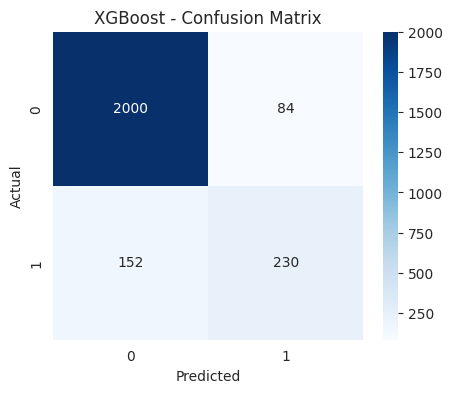

In [4]:
# Splitting dataset
X_train_shoppers, X_test_shoppers, y_train_shoppers, y_test_shoppers = train_test_split(X_shoppers, y_shoppers, test_size=0.2, random_state=42, stratify=y_shoppers)

# Scaling numerical features
scaler = StandardScaler()
X_train_shoppers = scaler.fit_transform(X_train_shoppers)
X_test_shoppers = scaler.transform(X_test_shoppers)

# Model training and evaluation
xgb_shoppers = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
start_time = time.time()
xgb_shoppers.fit(X_train_shoppers, y_train_shoppers)
xgb_shoppers_train_time = time.time() - start_time

# XGBoost Predictions
start_time = time.time()
xgb_y_pred_shoppers = xgb_shoppers.predict(X_test_shoppers)
xgb_shoppers_inference_time = time.time() - start_time


print(f"XGBoost Training time: {xgb_shoppers_train_time:.4f}")
print(f"XGBoost Inference time: {xgb_shoppers_inference_time:.4f}")

acc = accuracy_score(y_test_shoppers, xgb_y_pred_shoppers)
print(f"XGBoost Accuracy: {acc:.4f}")
print(classification_report(y_test_shoppers, xgb_y_pred_shoppers))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_shoppers, xgb_y_pred_shoppers), annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

TabPFN Implementation

In [5]:
# Train TabPFN Classifier
pfn_shoppers_model = TabPFNClassifier(device='cuda')  # Use 'cuda' if GPU is available
start_time = time.time()
pfn_shoppers_model.fit(X_train_shoppers, y_train_shoppers)
pfn_train_time = time.time() - start_time

# Predictions
start_time = time.time()
y_pred_shoopers_pfn = pfn_shoppers_model.predict(X_test_shoppers)
pfn_inference_time = time.time() - start_time

tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

In [7]:
def compute_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    # auc_roc = roc_auc_score(y_true, y_pred,multi_class='ovo')
    print(f"{model_name} Performance:\n Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f} \n")
    #print(f"{model_name} Performance:\n Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}\n")


compute_metrics(y_test_shoppers, xgb_y_pred_shoppers, "XGBoost")
compute_metrics(y_test_shoppers, y_pred_shoopers_pfn, "TabPFN")


# XGBoost Performance:
#  Accuracy: 0.9043, Precision: 0.8989, Recall: 0.9043, F1 Score: 0.9004 

# TabPFN Performance:
# Accuracy: 0.9023, Precision: 0.8977, Recall: 0.9023, F1 Score: 0.8994 

XGBoost Performance:
 Accuracy: 0.9043, Precision: 0.8989, Recall: 0.9043, F1 Score: 0.9004 

TabPFN Performance:
 Accuracy: 0.9023, Precision: 0.8977, Recall: 0.9023, F1 Score: 0.8994 



Table LLM

In [8]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("RUCKBReasoning/TableLLM-13b")
# tablellm_model = AutoModelForCausalLM.from_pretrained("RUCKBReasoning/TableLLM-13b")

# Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
# import torch


# tokenizer = AutoTokenizer.from_pretrained("RUCKBReasoning/TableLLM-7b")
# # Enable 4-bit quantization
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,  # Use 4-bit quantization
#     bnb_4bit_compute_dtype=torch.float16,
#     bnb_4bit_use_double_quant=True,
# )

# model = AutoModelForCausalLM.from_pretrained("RUCKBReasoning/TableLLM-7b",quantization_config=bnb_config, device_map="auto")

In [3]:
## resetting to base data, removing onehot encoding
online_original = fetch_ucirepo(id=468)
online_shoppers = online_original.data.original
# Define features and target variable
#X_shoppers = online_shoppers.drop(columns=['Revenue'])  # Features
#y_shoppers = online_shoppers['Revenue'].astype(int)  # Target
#X_train_shoppers, X_test_shoppers, y_train_shoppers, y_test_shoppers = train_test_split(X_shoppers, y_shoppers, test_size=0.2, random_state=42, stratify=y_shoppers)

from datasets import Dataset

def convert_to_table_prompt(df_row):
    """Format the tabular row into a natural language prompt for TableLLM"""
    prompt = f"Given the following online shopper session details, predict whether the user will make a purchase (1) or not (0):\n\n"
    prompt += "\n".join([f"{col}: {val}" for col, val in df_row.items()])
    prompt += "\n\nPrediction:"
    return prompt

# Apply transformation
online_shoppers["Revenue"] = online_shoppers["Revenue"].astype(int)
# print("Unique labels:", np.unique(online_shoppers["Revenue"]))  # Should be [0, 1]
# print(online_shoppers["Revenue"].isna().sum())

# online_shoppers["Revenue"] = online_shoppers["Revenue"].astype(str)
online_shoppers["prompt"] = online_shoppers.drop(columns=["Revenue"]).apply(convert_to_table_prompt, axis=1)


# Convert dataset to Hugging Face `Dataset` format
hf_dataset = Dataset.from_pandas(online_shoppers[["prompt", "Revenue"]])
hf_dataset = hf_dataset.rename_columns({"Revenue": "labels"})

print(hf_dataset)


Dataset({
    features: ['prompt', 'labels'],
    num_rows: 12330
})


In [4]:
print(hf_dataset[65])
#print(online_shoppers.loc[online_shoppers['Revenue'] == True])


{'prompt': 'Given the following online shopper session details, predict whether the user will make a purchase (1) or not (0):\n\nAdministrative: 3\nAdministrative_Duration: 87.83333333\nInformational: 0\nInformational_Duration: 0.0\nProductRelated: 27\nProductRelated_Duration: 798.3333333\nBounceRates: 0.0\nExitRates: 0.012643678\nPageValues: 22.9160357\nSpecialDay: 0.8\nMonth: Feb\nOperatingSystems: 2\nBrowser: 2\nRegion: 3\nTrafficType: 1\nVisitorType: Returning_Visitor\nWeekend: False\n\nPrediction:', 'labels': 1}


# Fine Tune Table LLM

In [5]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"


In [6]:
!pip show bitsandbytes
!pip install -U bitsandbytes
!pip uninstall transformers accelerate --yes
!pip install --upgrade transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 25.3 MB/s eta 0:00:00:00:0100:01
Found existing installation: transformers 4.47.0
Uninstalling transformers-4.47.0:
  Successfully uninstalled transformers-4.47.0
Found existing installation: accelerate 1.2.1
Uninstalling accelerate-1.2.1:
  Successfully uninstalled accelerate-1.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 82.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 19.0 MB/s eta 0:00:00


In [7]:
import torch
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq, AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import torch
import bitsandbytes as bnb
import transformers as tf
print("bitsandbytes version:", bnb.__version__)  # Ensure it is correctly installed
print("tf version:", tf.__version__)  
compute_dtype = getattr(torch, "float16")
print(compute_dtype)

bitsandbytes version: 0.45.2
tf version: 4.48.3
torch.float16


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
model_name = "RUCKBReasoning/TableLLM-7b"

# model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto", offload_folder="offload",)

bnb_config_gpu = BitsAndBytesConfig(
                load_in_4bit=True, 
                bnb_4bit_quant_type='nf4',
                bnb_4bit_compute_dtype=compute_dtype,
                bnb_4bit_use_double_quant=False, 
                llm_int8_enable_fp32_cpu_offload=True )

bnb_config_cpu = BitsAndBytesConfig(
    load_in_4bit=False,  # Disable quantization
    bnb_4bit_compute_dtype=torch.float32,  # Use float32 for CPU training
    llm_int8_enable_fp32_cpu_offload=True
)


tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    # quantization_config=bnb_config_cpu,
    # device_map={"": torch.cuda.current_device()} if device == "cuda" else {"": "cpu"}, # for gpu
    device_map={"": "cpu"},
    # torch_dtype=torch.float16, # for gpu
    torch_dtype=torch.float32,
    offload_folder="offload"
)
# 

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
#!pip install bitsandbytes
# !pip uninstall bitsandbytes --yes
print(f"Tokenizer vocabulary size: {len(tokenizer)}")
print(f"Model vocabulary size: {model.config.vocab_size}")

if len(tokenizer) == model.config.vocab_size:
    print("Tokenizer and model vocabulary sizes match.")
else:
    print("Warning: Tokenizer and model vocabulary sizes do NOT match!")


Tokenizer vocabulary size: 32017
Model vocabulary size: 32016


In [10]:
text = "TableLLM fine-tuning test"
tokens = tokenizer(text, return_tensors="pt")

# Print tokenized input
print("Tokens:", tokenizer.convert_ids_to_tokens(tokens["input_ids"].squeeze().tolist()))


Tokens: ['<s>', '▁Table', 'LL', 'M', '▁fine', '-', 't', 'uning', '▁test']


In [11]:
print(tokenizer.special_tokens_map)
print(tokenizer.additional_special_tokens)


{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '[PAD]'}
[]


In [11]:
model.resize_token_embeddings(len(tokenizer))


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(32017, 4096)

In [12]:
print(f"Updated Tokenizer Vocab Size: {len(tokenizer)}")
print(f"Updated Model Vocab Size: {model.config.vocab_size}")


Updated Tokenizer Vocab Size: 32017
Updated Model Vocab Size: 32017


In [13]:
from peft import LoraConfig, get_peft_model

# Define LoRA Configuration
lora_config = LoraConfig(
    r=8,  # Rank of the LoRA update matrices
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],  # Apply LoRA only to attention layers
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"  # AutoModelForCausalLM is a causal language model
)

# Attach LoRA adapters
peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()

trainable params: 4,194,304 || all params: 26,170,765,312 || trainable%: 0.0160


In [14]:
print(f"Updated Model Vocab Size: {peft_model.config.vocab_size}")

Updated Model Vocab Size: 32017


In [15]:
device = torch.device("cpu")  # Use "cuda" if using GPU
print(device)
peft_model.to(device)  # Move model to CPU


cpu


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32017, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear4

In [16]:
# Tokenize dataset
print(device)
def preprocess_function(examples):
    model_inputs = tokenizer(examples["prompt"], padding="longest", truncation=True) #changing padding to longest for cuda error
    model_inputs["labels"] = examples["labels"]
    # model_inputs["labels"] = tokenizer(examples["labels"], truncation=True)["input_ids"] # avoid padding here for cuda error padding="max_length"
        # Move tensors to the same device as the model
    # model_inputs = {key: torch.tensor(val).to(device) for key, val in model_inputs.items()} # needed for GPU
    
    return model_inputs
    # model_inputs["labels"] = examples["labels"]


tokenized_dataset = hf_dataset.map(preprocess_function, batched=True)

# Data collator for training
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=peft_model)



cpu


Map:   0%|          | 0/12330 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [17]:
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)  # Should print only LoRA parameters


base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight torch.Size([8, 4096])
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight torch.Size([4096, 8])
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight torch.Size([8, 4096])
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight torch.Size([4096, 8])
base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight torch.Size([8, 4096])
base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight torch.Size([4096, 8])
base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight torch.Size([8, 4096])
base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight torch.Size([4096, 8])
base_model.model.model.layers.2.self_attn.q_proj.lora_A.default.weight torch.Size([8, 4096])
base_model.model.model.layers.2.self_attn.q_proj.lora_B.default.weight torch.Size([4096, 8])
base_model.model.model.layers.2.self_attn.v_proj.lora_A.default.weight

In [18]:
from transformers import TrainingArguments, Trainer
# !export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

# torch.cuda.empty_cache()

# Assuming 'peft_model' is your model

# peft_model.to_empty(device='cpu')  # If the model is in a meta state, use this

# Move the model to the desired device (cuda, cpu)
# peft_model.to('cpu')  # Move the model to the target device

# tokenized_dataset.to('cpu')

In [19]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

training_args = TrainingArguments(
    output_dir="./fine_tuned_tablellm",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,  # Use a slightly higher learning rate for LoRA
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True if torch.cuda.is_available() else False, # changing to false to avoid cuda error
    push_to_hub=False,
    gradient_accumulation_steps=4
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset,  # Make sure dataset is properly tokenized
    eval_dataset=tokenized_dataset,
    tokenizer=tokenizer
)

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


In [20]:
  # Debugging flag

trainer.train()

ValueError: You can't train a model that has been loaded in 8-bit or 4-bit precision on a different device than the one you're training on. Make sure you loaded the model on the correct device using for example `device_map={'':torch.cuda.current_device()}` or `device_map={'':torch.xpu.current_device()}`

In [ ]:
#Saving fine-tuned model
trainer.save_model("./fine_tuned_tablellm")
tokenizer.save_pretrained("./fine_tuned_tablellm")


In [ ]:
import torch
# Convert tabular data to text format for Table LLM
def convert_to_table_prompt(df_row):
    prompt = f"Given the following online shopper session details, predict whether the user will make a purchase (1) or not (0):\n\n"
    prompt += "\n".join([f"{col}: {val}" for col, val in df_row.items()])
    prompt += "\n\nPrediction:"
    return prompt


features = online_shoppers.drop(columns=["Revenue"])

X_test_shoppers = pd.DataFrame(X_test_shoppers, columns=features.columns) 
X_test_text = X_test_shoppers.apply(convert_to_table_prompt, axis=1).tolist()

print(X_test_text)
X_test_text_sampled = X_test_text[:10]
y_test_sampled = y_test_shoppers[:10]
print(X_test_text_sampled)
print(y_test_sampled)

In [ ]:
# Tokenize and generate predictions
import re
y_pred_tablellm = []
for text in X_test_text_sampled:
# text = "Given the following online shopper session details, predict whether the user will make a purchase (1) or not (0).:\n\nAdministrative: 1\nAdministrative_Duration: 4.0\nInformational: 0\nInformational_Duration: 0.0\nProductRelated: 13\nProductRelated_Duration: 161.1666667\nBounceRates: 0.024615385\nExitRates: 0.061538462\nPageValues: 0.0\nSpecialDay: 0.6\nMonth: May\nOperatingSystems: 2\nBrowser: 5\nRegion: 9\nTrafficType: 5\nVisitorType: Returning_Visitor\nWeekend: False\n\nPrediction:"
    inputs = tokenizer(text, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=256)
    y_preds = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(y_preds)
    # Regular expression to match the 'Prediction' key and extract its value
    match = re.search(r'Prediction:\s*(\d+)', y_preds)

    if match:
        prediction_value = match.group(1)
        print(prediction_value)
        y_pred_tablellm.append(prediction_value)
    else:
        print("Prediction key not found")
        y_pred_tablellm.append(-1)


# Evaluate Performance
accuracy = accuracy_score(y_test_sampled, y_pred_tablellm)
# print(f"TableLLM 13B Accuracy: {accuracy:.4f}")

In [ ]:
print(accuracy)
print(y_pred_tablellm)
print(y_test_sampled)